# Transformation examples

## Introduction
This notebook illustrates some tranformation capabilities provided by plaid-ops. 

In [ ]:
import os

from datasets import load_dataset
from IPython.display import display
from PIL import Image
from plaid.bridges.huggingface_bridge import (
    huggingface_dataset_to_plaid,
    huggingface_description_to_problem_definition,
)

from plaid_ops.common.visualization import plot_sample_field
from plaid_ops.mesh.feature_engineering import update_dataset_with_sdf
from plaid_ops.mesh.transformations import (
    compute_bounding_box,
    project_on_other_datset,
    project_on_regular_grid,
)

hf_dataset = load_dataset(
    "PLAID-datasets/2D_Multiscale_Hyperelasticity", split="all_samples"
)
pb_def = huggingface_description_to_problem_definition(hf_dataset.info.description)
ids = pb_def.get_split("DOE_train")[:2]
dataset, _ = huggingface_dataset_to_plaid(hf_dataset, ids=ids, processes_number=2)

/home/fabien/miniconda3/envs/plaid-ops/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Kokkos::OpenMP::initialize WARNING: OMP_PROC_BIND environment variable not set
  In general, for best performance with OpenMP 4.0 or better set OMP_PROC_BIND=spread and OMP_PLACES=threads
  For best performance with OpenMP 3.1 set OMP_PROC_BIND=true
  For unit testing set OMP_PROC_BIND=false



Converting Hugging Face dataset to plaid dataset...


100%|██████████| 2/2 [00:00<00:00, 141.82it/s]


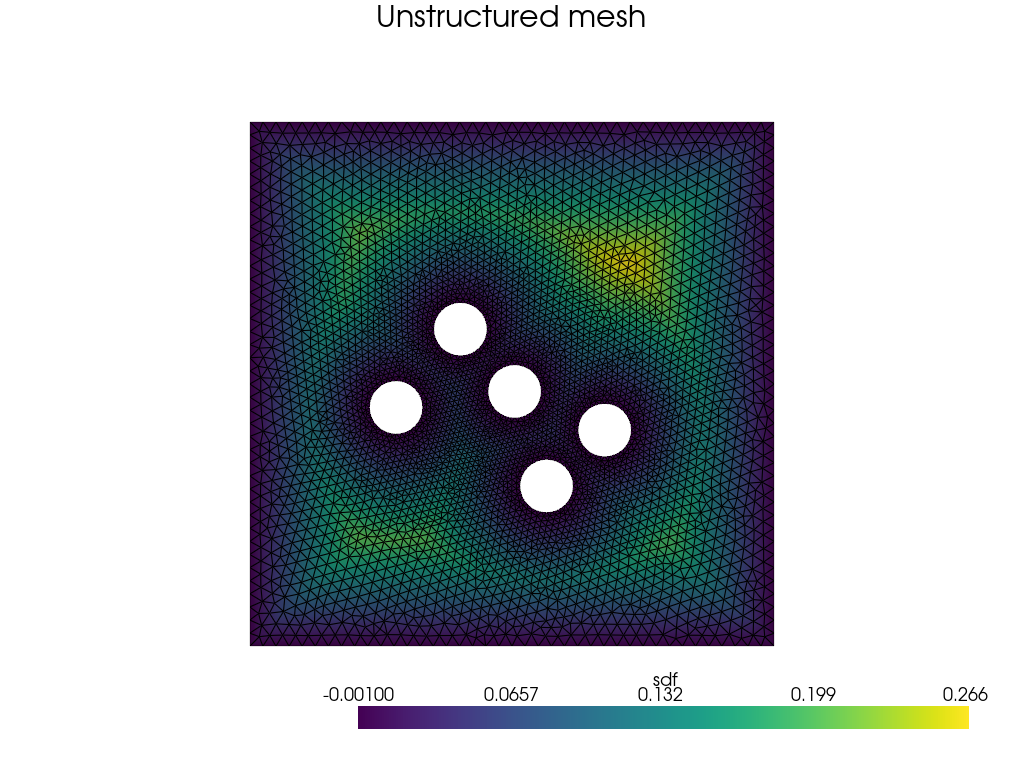

In [ ]:
dataset = update_dataset_with_sdf(dataset)

img_name = "transformation_1.png"
if os.environ.get("READTHEDOCS") == "True":
    display(Image(filename=img_name))
else:
    img_array = plot_sample_field(
        dataset[ids[0]],
        "sdf",
        title="Unstructured mesh",
        show_edges=True,
        scalar_bar_args={"title": "sdf"},
    )
    img = Image.fromarray(img_array)
    img.save(img_name)
    display(img)

100%|██████████| 2/2 [00:00<00:00, 43.32it/s]


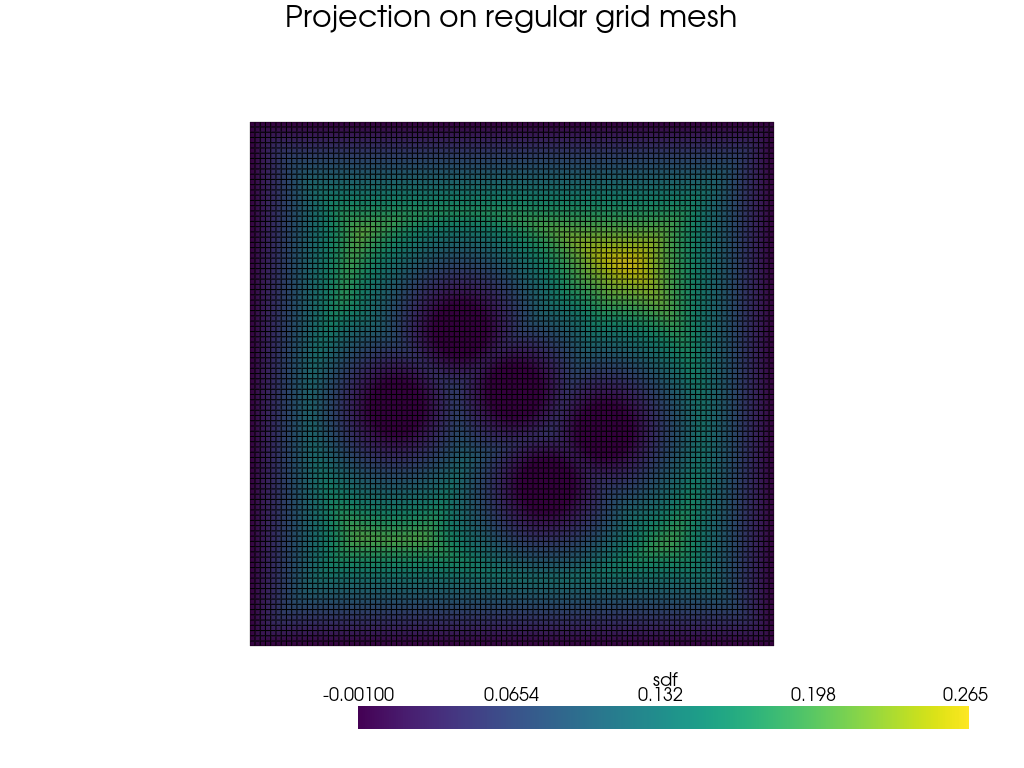

In [ ]:
bbox = compute_bounding_box(dataset)
projected_dataset = project_on_regular_grid(
    dataset, dimensions=[101, 101], bbox=bbox, verbose=True
)

img_name = "transformation_2.png"
if os.environ.get("READTHEDOCS") == "True":
    display(Image(filename=img_name))
else:
    img_array = img = plot_sample_field(
        projected_dataset[ids[0]],
        "sdf",
        title="Projection on regular grid mesh",
        show_edges=True,
        scalar_bar_args={"title": "sdf"},
    )
    img = Image.fromarray(img_array)
    img.save(img_name)
    display(img)

100%|██████████| 2/2 [00:00<00:00, 40.78it/s]


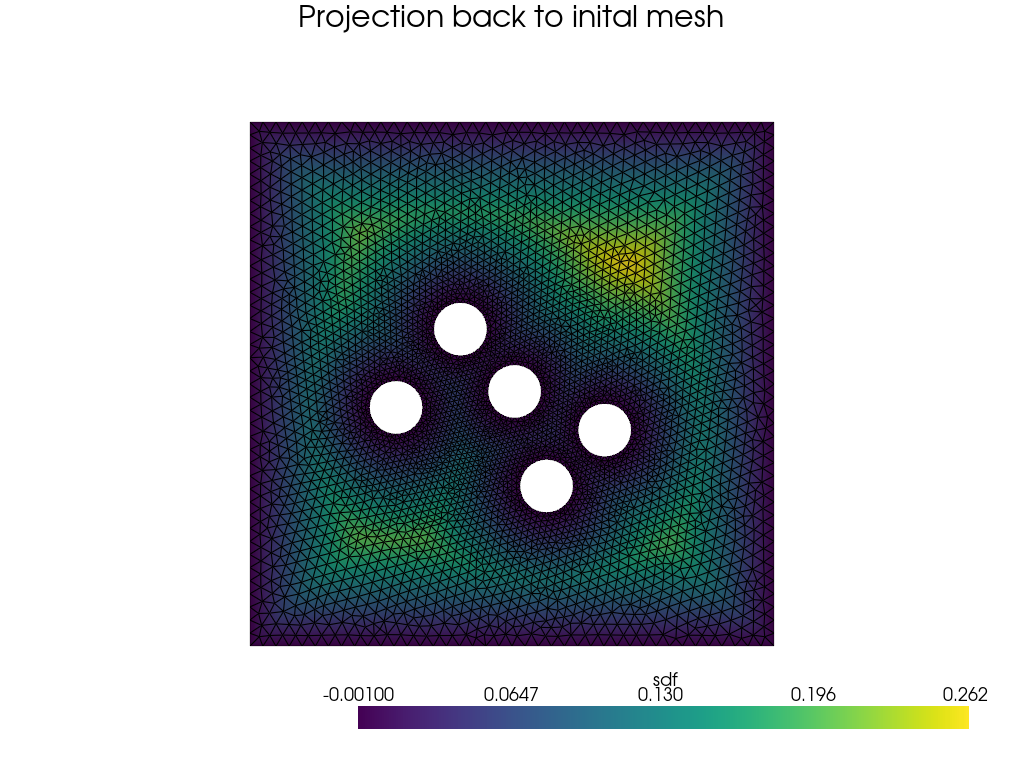

In [ ]:
inv_projected_dataset = project_on_other_datset(
    projected_dataset, dataset, verbose=True
)

img_name = "transformation_3.png"
if os.environ.get("READTHEDOCS") == "True":
    display(Image(filename=img_name))
else:
    img_array = img = plot_sample_field(
        inv_projected_dataset[ids[0]],
        "sdf",
        title="Projection back to inital mesh",
        show_edges=True,
        scalar_bar_args={"title": "sdf"},
    )
    img = Image.fromarray(img_array)
    img.save(img_name)
    display(img)